In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
det_class_path = 'stage_2_detailed_class_info.csv'
bbox_path = 'stage_2_train_labels.csv'
dicom_dir = 'stage_2_train_images/'

30227 class infos loaded
26684 patient cases


,patientId,class
1118,0ccff729-ee71-4a5f-ad01-ce12ab162afa,Lung Opacity
11733,7934f518-dbaa-4201-922b-1bc93a245e84,Lung Opacity
16474,9f5fbcfa-4e19-4fe4-991c-fe385baff790,Normal


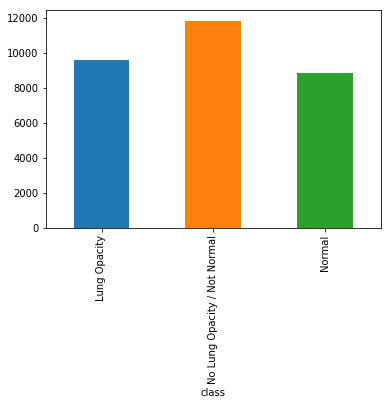

In [2]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [3]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

30227 boxes loaded
26684 patient cases


,patientId,x,y,width,height,Target
13551,880f0e16-a8d8-4ff9-ba21-5cde5c2860f8,NaN,NaN,NaN,NaN,0
29917,29a2fb4c-481c-4147-89ad-5b6d1e343903,NaN,NaN,NaN,NaN,0
21605,c43c9657-9079-4a58-8801-7b701114143b,NaN,NaN,NaN,NaN,0


In [4]:
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='inner', on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')

37629 combined cases


In [5]:
comb_bbox_df = pd.concat([bbox_df, det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
29003,002c591d-df62-4e34-8eda-838c664430a9,NaN,NaN,NaN,NaN,0,Normal
25160,e19147ad-0b2d-4b0a-aa3e-1bebb6a55954,NaN,NaN,NaN,NaN,0,Normal
2129,27532c20-7a0b-45b2-b229-496126a327ad,234.0,370.0,183.0,291.0,1,Lung Opacity


In [6]:
box_df = comb_bbox_df.groupby('patientId').size().reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [7]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [8]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())

26684 images found


In [9]:
image_bbox_df = pd.merge(comb_box_df,image_df, on='patientId',how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images\0004cfab-14fd-4e49-80ba-6...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images\000924cf-0f8d-42bd-9158-1...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,stage_2_train_images\000db696-cf54-4385-b10b-6...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,stage_2_train_images\000db696-cf54-4385-b10b-6...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,stage_2_train_images\000fe35a-2649-43d4-b027-e...


In [10]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']

In [11]:
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)

In [12]:
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)

,BodyPartExamined,PatientSex,ViewPosition
count,26684,26684,26684
unique,1,2,2
top,CHEST,M,PA
freq,26684,15166,14511


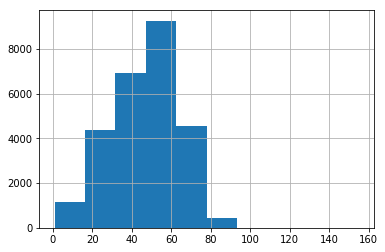

In [13]:
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [14]:
image_full_df = pd.merge(image_df,image_meta_df,on='path')

In [15]:
sample_df = image_bbox_df.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path
0,5593c1db-7337-44b3-8d03-7a992decbc3b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images\5593c1db-7337-44b3-8d03-7...
1,5b23de86-c4a5-4c55-b38f-18155a87930a,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images\5b23de86-c4a5-4c55-b38f-1...
2,fb82c2c6-3560-400e-a6d3-1b8b473db183,245.0,435.0,126.0,225.0,1,Lung Opacity,1,stage_2_train_images\fb82c2c6-3560-400e-a6d3-1...
3,717269da-561f-461f-93c5-f5047f91e5b5,196.0,206.0,270.0,569.0,1,Lung Opacity,2,stage_2_train_images\717269da-561f-461f-93c5-f...
4,717269da-561f-461f-93c5-f5047f91e5b5,580.0,247.0,270.0,541.0,1,Lung Opacity,2,stage_2_train_images\717269da-561f-461f-93c5-f...
5,7c086e53-4bad-4bc6-9ff6-292614b69e07,180.0,524.0,141.0,150.0,1,Lung Opacity,3,stage_2_train_images\7c086e53-4bad-4bc6-9ff6-2...
6,7c086e53-4bad-4bc6-9ff6-292614b69e07,583.0,394.0,107.0,149.0,1,Lung Opacity,3,stage_2_train_images\7c086e53-4bad-4bc6-9ff6-2...
7,7c086e53-4bad-4bc6-9ff6-292614b69e07,233.0,322.0,127.0,107.0,1,Lung Opacity,3,stage_2_train_images\7c086e53-4bad-4bc6-9ff6-2...
8,1c44e0a4-4612-438f-9a83-8d5bf919cb67,658.0,346.0,145.0,122.0,1,Lung Opacity,4,stage_2_train_images\1c44e0a4-4612-438f-9a83-8...
9,1c44e0a4-4612-438f-9a83-8d5bf919cb67,258.0,786.0,157.0,151.0,1,Lung Opacity,4,stage_2_train_images\1c44e0a4-4612-438f-9a83-8...


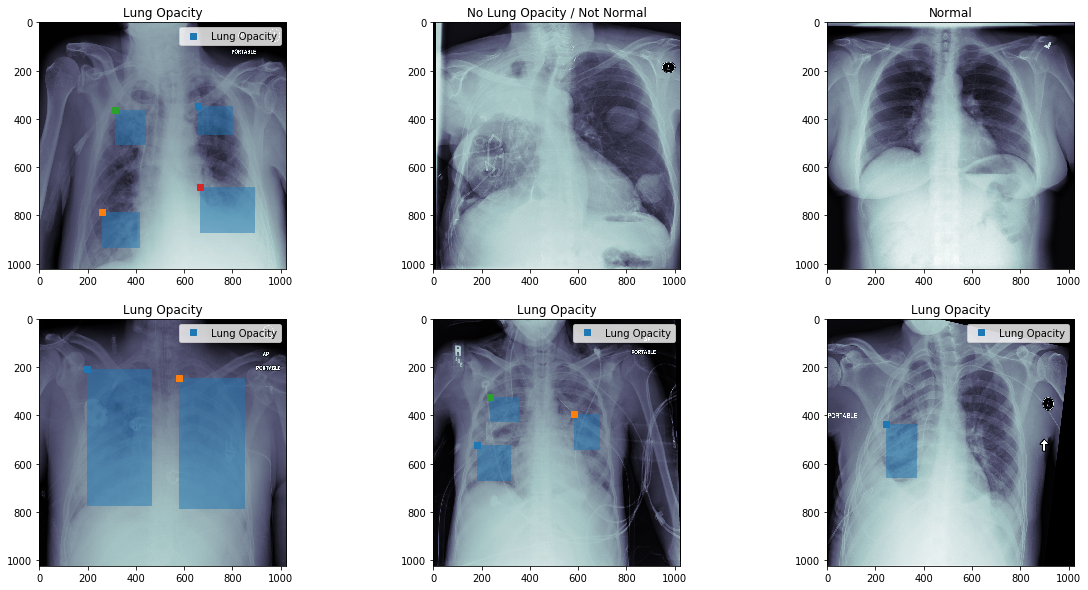

In [16]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

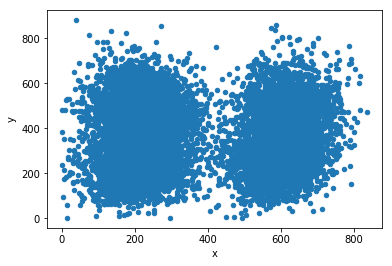

In [17]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

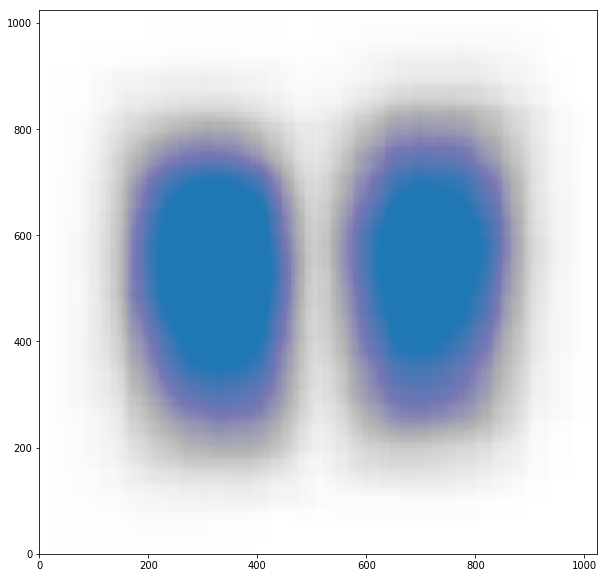

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

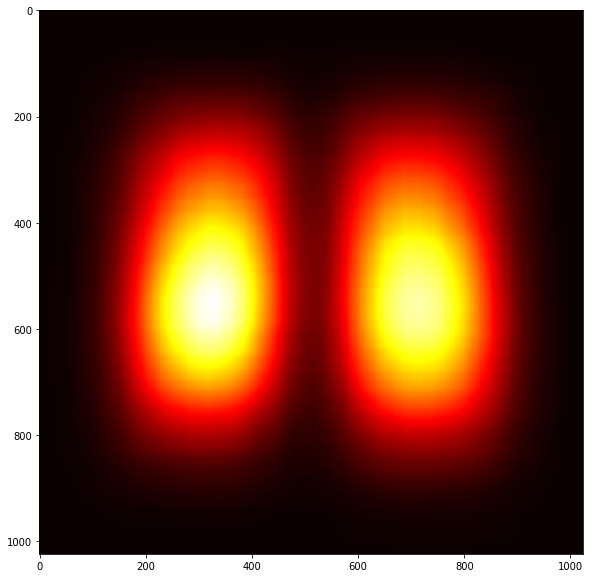

In [19]:
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

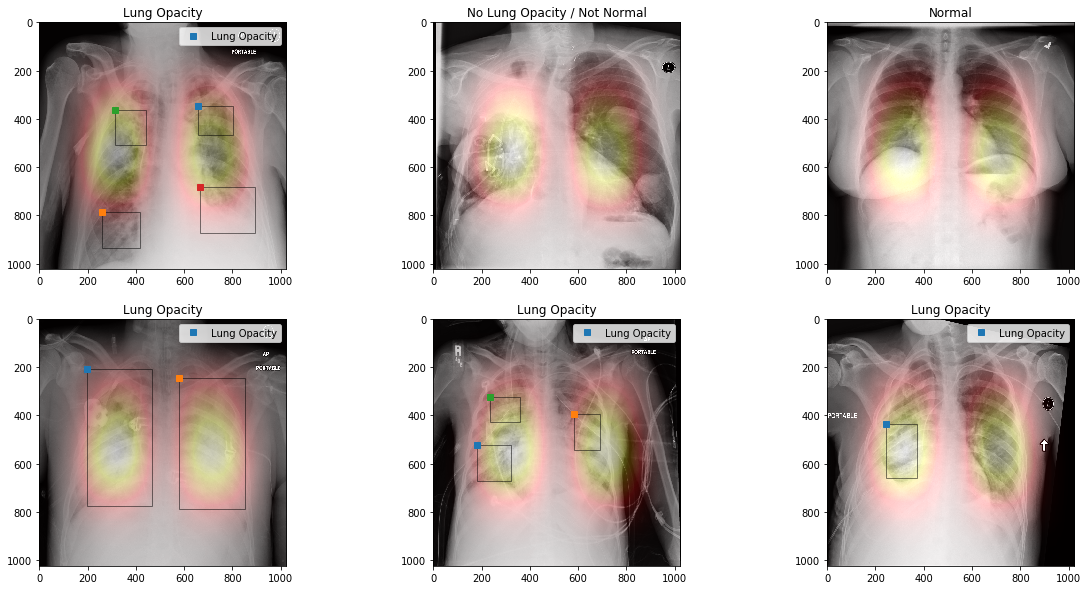

In [20]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

In [21]:
image_bbox_df.to_csv('image_bbox_full_1029-01.csv', index=False)

In [22]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

In [23]:
# empty dictionary
nodule_locations = {}
# load table
with open(os.path.join('image_bbox_full_1029-01.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        nodule = rows[5]
        # if row contains a nodule add label to dictionary
        # which contains a list of nodule locations per filename
        if nodule == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save nodule location in dictionary
            if filename in nodule_locations:
                nodule_locations[filename].append(location)
            else:
                nodule_locations[filename] = [location]

In [24]:
# load and shuffle filenames
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('train samples', len(train_filenames))
print('valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

train samples 24124
valid samples 2560


Total train images: 26684
Images with nodule: 6012


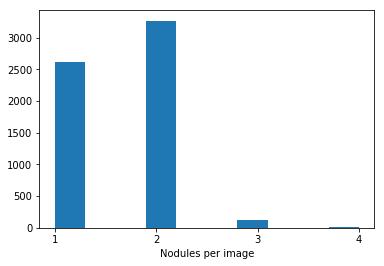

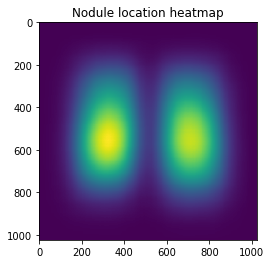

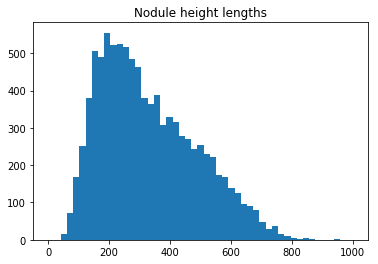

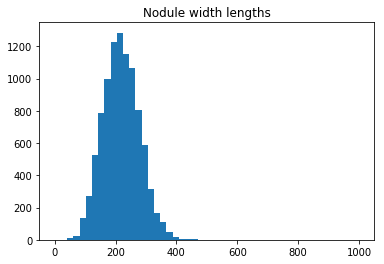

Minimum nodule height: 45
Minimum nodule width:  40


In [25]:
print('Total train images:',len(filenames))
print('Images with nodule:', len(nodule_locations))

ns = [len(value) for value in nodule_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Nodules per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in nodule_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Nodule location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Nodule height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Nodule width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum nodule height:', np.min(hs))
print('Minimum nodule width: ', np.min(ws))

[ 195.78511166  227.92770885]
[ 257.54216524  503.8031339 ]


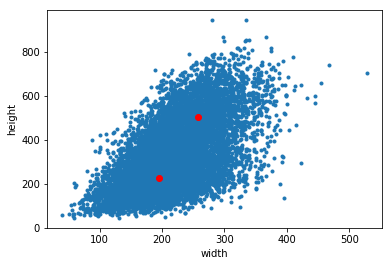

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(np.array([ws, hs]).T)
centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(ws, hs, marker='.')
plt.xlabel('width')
plt.ylabel('height')
for center in centers:
    print(center)
    plt.scatter(center[0], center[1], c='red')
plt.show()

In [27]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=32, image_size=512, shuffle=True, predict=False, augment = False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in nodule_locations:
            # loop through nodules
            for location in nodule_locations[filename]:
                # add 1's at the location of the nodule
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [28]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=5):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [29]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [30]:
# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer=keras.optimizers.Adam(lr=.01),loss=keras.losses.binary_crossentropy,metrics=['accuracy', mean_iou])

In [31]:
# create train and validation generators
folder = 'stage_2_train_images'
train_gen = generator(folder, train_filenames, nodule_locations, batch_size=8, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, nodule_locations, batch_size=8, image_size=256, shuffle=False, predict=False)

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=30, shuffle=True, verbose=1)

Epoch 1/30
3015/3015 [==============================] - 921s 305ms/step - loss: 0.1004 - acc: 0.9735 - mean_iou: 0.7742 - val_loss: 0.1084 - val_acc: 0.9733 - val_mean_iou: 0.7727
Epoch 2/30
3015/3015 [==============================] - 899s 298ms/step - loss: 0.0868 - acc: 0.9736 - mean_iou: 0.7726 - val_loss: 0.1315 - val_acc: 0.9733 - val_mean_iou: 0.7727
Epoch 3/30
3015/3015 [==============================] - 900s 298ms/step - loss: 0.0801 - acc: 0.9737 - mean_iou: 0.7522 - val_loss: 0.0964 - val_acc: 0.9735 - val_mean_iou: 0.7687
Epoch 4/30
3015/3015 [==============================] - 901s 299ms/step - loss: 0.0745 - acc: 0.9744 - mean_iou: 0.7470 - val_loss: 0.0784 - val_acc: 0.9748 - val_mean_iou: 0.7617
Epoch 5/30
3015/3015 [==============================] - 897s 298ms/step - loss: 0.0703 - acc: 0.9751 - mean_iou: 0.7483 - val_loss: 0.0711 - val_acc: 0.9744 - val_mean_iou: 0.7706
Epoch 6/30
3015/3015 [==============================] - 897s 297ms/step - loss: 0.0674 - acc: 0.9755

In [ ]:
model.save("model_1029-04.h5")

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
# load and shuffle filenames
folder = 'stage_2_test_images'
test_filenames = os.listdir(folder)
print('test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission_1029-04.csv')